# Person Analysis
**Aims :**

1. We want to see how a person behaves at each vote -> Create a DataFrame that records whether the person voted like the average of the party (Could be a good thing to have what the party instructs to vote at this time), and whether the person was present.
2. We want to compute some global statistics about each person :
    - Percentage of the time during which a person votes like his party
    - Percentage of abstention
    - Percentage of absence (Days or vote the person did not take ?)
    - Time at which he entered the parliament.
    
    
To do so, we need a few things :

1. The *Vote* file that we parsed, that records all the votations taking place at the parliament. We will need to find the earliest law that each person votes, and then, from this, count all the laws that have been voted, and count the number of votes the person did not attend.
2. The *Voting* file will be our primary source of informations, recording all the votes of every person at the parliament. We will need to split it by each person, which was already done beforehand in the `01-ML` folder.

**Ideal visualisation :** 
Whenever we enter the page about someone -> Some general information (from Gaël's team maybe), and then, a graph with the votes (Q: What to display ?)

-> Idea : a vertical bar, which height corresponds to the number of law that the deputy voted on. Inside the vertical bar, show 5 sectors : percentage of yes/no/abstention/absent/president for each period. Then, click on it and a detailled view on a single period appears -> Same kind of graph, except the guy voted yes or no for a law (color for yes/no/abstention, other color for absent) + Color for whether the law was passed or not.

Maybe use [stacked bar chart](http://bl.ocks.org/mbostock/3886208) for the overall view (shift it so the bars are horizontal) or alternatively [grouped to stacked](https://bl.ocks.org/mbostock/3943967)


When you click on a session, maybe display something like [Table with bar chart](http://bl.ocks.org/llad/3918637) with change to another page, with either again the same chart, or a [grouped bar chart](http://bl.ocks.org/mbostock/3887051), or we could use a mix between [collapsed tree](http://bl.ocks.org/mbostock/1093025) and a [dendrogram with bars](https://bl.ocks.org/dahis39/f28369f0b17b456ac2f1fa9b937c5002)

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from helpers import load_vote_df, load_voting,format_voting_session, split_df_dict
%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

# 1. Loading and formatting the Vote DataFrame
Convert *date* into *datetime* format with `pd.to_datetime` allows us to sort the dates the way we want.

- *Attributes of datetime object:* year, month, day, hour, minute, second, microsecond, and tzinfo.

A few useful German words unknown to me.

*Antrag* : demande


In [2]:
VOTE_DICT  = {1:'Yes', 2:'No', 3:'Abstention', 5:'Absent', 6:'Excused', 7:'President'}

vote_df = load_vote_df()

Entries in the DataFrame (11182, 16)


N.B. `SessionName` field is rubbish -> The correct session is not the one mentionned in it. Hence we need to merge the Session ID with the one from the scraped session.

Looking at the Swiss Parties, their real names and abbreviation are the following:

- PLR : Parti libéral-radical (PLR. Les Libéraux-Radicaux)
- PDC : Parti démocrate-chrétien suisse
- PS  : Parti socialiste suisse
- UDC :	Union démocratique du centre
- PES :	Parti écologiste suisse (Les Verts)
- PVL :	Parti vert-libéral
- PBD :	Parti Bourgeois-Démocratique

However, we talk about the *Groupes Parlementaires*, which are not exactly the same as the Parties. We will work with those here.

# 2. Load the Voting DataFrame

**format_voting_session :** Appends session related fields to the voting data, preparing for aggregation.

In [3]:
voting_df = format_voting_session(load_voting())

voting_df.head()

Entries in the DataFrame (1713854, 26)


,Name,BillTitle,Decision,BusinessShortNumber,ParlGroupName,ParlGroupCode,IdVote,IdSession,VoteEnd,SessionName,Date
0,Adèle Thorens Goumaz,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,Groupe écologiste,G,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05
1,Ada Marra,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,Groupe socialiste,S,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05
2,Tiana Angelina Moser,Arrêté fédéral relatif à l’initiative populair...,Absent,13.093,Groupe vert'libéral,GL,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05
3,Sylvie Perrinjaquet,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,Groupe radical-démocratique,RL,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05
4,Natalie Rickli,Arrêté fédéral relatif à l’initiative populair...,Abstention,13.093,"Groupe des Paysans, Artisans et Bourgeois",V,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05


Still has a lot of data, but we tried to keep a minimum of it to make it readable by a human as well as having all the information we need to display.

# 3. Format the DataFrame
## a) Session level statistics for each of the deputies.
Now, format the way we want to for exporting for each person

First of all : Global stats -> *Yes/No/Abstention/Absence/Excused/President* at a session level.

In [4]:
voting_dict = split_df_dict(voting_df, 'Name')

Number of unique entries in Name : 358


Summary of the different votes possible

|**1** | **2** | **3**      | **4**    | **5**               | **6** |                **7**                       |
|------|-------|------------|----------|---------------------|-------|--------------------------------------------|
| Yes  | No    | Abstention | No entry | Did not participate |Excused| The president of the session does not vote |


Counting the percentage of abstention by person, in order to see whether there is a person that would abstain significantly more often than the rest. It does not appear to be the case.

In [5]:
#count_abst = lambda x: 
voting_test = voting_df[['Name','Decision']].groupby('Name').apply(lambda x: np.sum(x.Decision==3)/len(x.Decision))
voting_test.sort_values(ascending=False).head()

Name
Yvonne Gilli          0.0
Hans Rutschmann       0.0
Franz Grüter          0.0
Franz Ruppen          0.0
Franziska Teuscher    0.0
dtype: float64

Simply trying the aggregation at a session level for a deputy in particular, it will have to be done for every single one after, then exporting the resulting DataFrame to a `.csv` or `.json` to make it readable with `javascript`.

In [6]:
test = voting_dict['Filippo Leutenegger']
test.head()

,BillTitle,Decision,BusinessShortNumber,ParlGroupName,ParlGroupCode,IdVote,IdSession,VoteEnd,SessionName,Date
77,Arrêté fédéral relatif à l’initiative populair...,Absent,13.093,Groupe radical-démocratique,RL,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05
277,Arrêté fédéral relatif à l’initiative populair...,Yes,13.057,Groupe radical-démocratique,RL,13909,4913,2014-05-06,Session spéciale mai 2014,2014-05-05
477,Loi fédérale sur les entreprises de transport ...,Abstention,13.072,Groupe radical-démocratique,RL,13911,4913,2014-05-06,Session spéciale mai 2014,2014-05-05
677,Loi sur le transport de voyageurs (LTV),Yes,13.072,Groupe radical-démocratique,RL,13912,4913,2014-05-06,Session spéciale mai 2014,2014-05-05
877,Loi sur le transport de voyageurs (LTV),Abstention,13.072,Groupe radical-démocratique,RL,13913,4913,2014-05-06,Session spéciale mai 2014,2014-05-05


In [7]:
voting_dict['Filippo Leutenegger'].loc[voting_dict['Filippo Leutenegger'].IdSession==4913].SessionName.unique()[0]

'Session spéciale mai 2014'

In [8]:
test = voting_dict['Filippo Leutenegger'].groupby(['IdSession','SessionName','Date'])


count_yes = lambda x: np.sum(x==VOTE_DICT[1])
count_no = lambda x: np.sum(x==VOTE_DICT[2])
count_abstention = lambda x: np.sum(x==VOTE_DICT[3])
count_absent = lambda x: np.sum(x==VOTE_DICT[5])
count_excused = lambda x: np.sum(x==VOTE_DICT[6])
count_president = lambda x: np.sum(x==VOTE_DICT[7])
name_session = lambda x: x.unique()[0]
year_session = lambda x: x.unique()[0]

test = test.agg({'Decision':{'Yes': count_yes, 'No': count_no,'Abstention': count_abstention,
                'Excused':count_excused, 'Absent':count_absent, 'President':count_president}})

test.columns = test.columns.droplevel(0)
#test_grouped = test_grouped.join(test['SessionName','Year'])
test = test.reset_index().set_index('IdSession')
test = test[['Yes','No','Abstention','Absent','Excused','President','SessionName','Date']]
#test['Total'] = test.sum(axis=1)
test

,Yes,No,Abstention,Absent,Excused,President,SessionName,Date
IdSession,,,,,,,,
4811,107,78,27,88,0,0,Session d'automne 2009,2009-09-07
4812,145,86,26,47,0,0,Session d'hiver 2009,2009-11-23
4813,98,51,7,142,0,0,Session de printemps 2010,2010-03-01
4814,159,64,35,44,0,0,Session d'été 2010,2010-05-31
4815,129,56,18,57,0,0,Session d'automne 2010,2010-09-13
4816,115,40,16,71,0,0,Session d'hiver 2010,2010-11-29
4817,121,62,32,55,0,0,Session de printemps 2011,2011-02-28
4818,20,34,5,43,0,0,Session spéciale avril 2011,2011-04-11
4819,167,105,13,119,0,0,Session d'été 2011,2011-05-30


Aggregating further up at a yearly level and displaying the result.

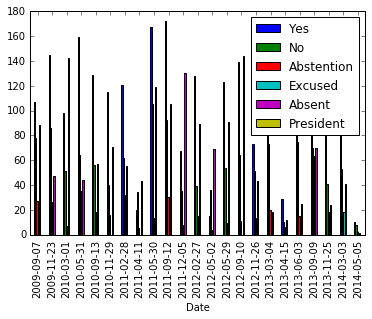

In [9]:
test = test.drop('SessionName',1).groupby('Date').apply(sum).drop('Date',1)
test['Presence'] = test['Yes']+test['No']+test['Abstention']+test['President']
test['Absence'] = test['Excused']+test['Absent']

test.plot.bar(x=test.index, y=['Yes','No','Abstention','Excused','Absent','President'])
#test.plot.bar(x=test.index,y=['Presence','Absence'])

N.B. We checked for consistency, and from the time the person is elected, he appears at all subsequent votes (the sum of all the fields will give the total number of votes from the session)

### Exporting the results to the `analysis` folder in the datas 

In [10]:
from helpers import export_session_vote_csv
directory = '../../datas/analysis/voting_agg/'
if not os.path.exists(directory):
    os.makedirs(directory)
    
for deputee, df in voting_dict.items():
    export_session_vote_csv(directory,deputee,df,'_vote_session.csv')
    
df_grouped = df.groupby(['IdSession','SessionName','Date'])

## b) Detailled version for the votes of each deputee
Here, we store everything, sorted by session and time, that each deputee voted. 

Before adding fields, let us first merge some parts of the vote `DataFrame` with the voting `DataFrame`

In [11]:
def merge_vote_voting(vote_df, voting_df):
    vote_info_df = vote_df[['Subject','MeaningNo','MeaningYes','ID']]
    vote_info_df.columns = ['Subject','MeaningNo','MeaningYes','IdVote']
    
    return pd.merge(voting_df, vote_info_df, on ='IdVote')

voting_df = merge_vote_voting(vote_df,voting_df)
voting_df.head()

,Name,BillTitle,Decision,BusinessShortNumber,ParlGroupName,ParlGroupCode,IdVote,IdSession,VoteEnd,SessionName,Date,Subject,MeaningNo,MeaningYes
0,Adèle Thorens Goumaz,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,Groupe écologiste,G,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05,Art. 2,Antrag der SVP-Fraktion (Empfehlung auf Annahm...,Antrag der Kommission (Empfehlung auf Ablehung...
1,Ada Marra,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,Groupe socialiste,S,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05,Art. 2,Antrag der SVP-Fraktion (Empfehlung auf Annahm...,Antrag der Kommission (Empfehlung auf Ablehung...
2,Tiana Angelina Moser,Arrêté fédéral relatif à l’initiative populair...,Absent,13.093,Groupe vert'libéral,GL,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05,Art. 2,Antrag der SVP-Fraktion (Empfehlung auf Annahm...,Antrag der Kommission (Empfehlung auf Ablehung...
3,Sylvie Perrinjaquet,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,Groupe radical-démocratique,RL,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05,Art. 2,Antrag der SVP-Fraktion (Empfehlung auf Annahm...,Antrag der Kommission (Empfehlung auf Ablehung...
4,Natalie Rickli,Arrêté fédéral relatif à l’initiative populair...,Abstention,13.093,"Groupe des Paysans, Artisans et Bourgeois",V,13907,4913,2014-05-05,Session spéciale mai 2014,2014-05-05,Art. 2,Antrag der SVP-Fraktion (Empfehlung auf Annahm...,Antrag der Kommission (Empfehlung auf Ablehung...


First of all, count the overall result of the vote for the whole councile considered

In [31]:
def format_result_vote(voting_df):
    # Setting Name, Party and Topic as indices
    result_df = voting_df.set_index('IdVote')[['Decision']]

    result_df = result_df.groupby(level='IdVote')
    
    # Functions to count number of yes/no/absentions, same principle as before
    count_total = lambda x: sum(x==VOTE_DICT[1])+sum(x==VOTE_DICT[2])+sum(x==VOTE_DICT[3])
    count_yes = lambda x: int(round(100*np.sum(x==VOTE_DICT[1])/count_total(x),0))
    count_no = lambda x: int(round(100*np.sum(x==VOTE_DICT[2])/count_total(x),0))
    count_abstention = lambda x: int(round(100*np.sum(x==VOTE_DICT[3])/count_total(x),0))

    result_df = result_df.agg({'Decision':{'Total_Yes': count_yes, 'Total_No': count_no,'Total_Abstention': count_abstention,
                                          'Total_Total': count_total}})
    result_df.columns = result_df.columns.droplevel(0)
    result_df.reset_index(inplace=True)
    return pd.merge(voting_df, result_df, on= 'IdVote')

Secondly, compute the voting result aggregated to a party level, to be able to know whetether someone voted like his party

In [32]:
def format_party_voting(voting_df):
    # Setting Name, Party and Topic as indices
    party_voting_df = voting_df.set_index(['ParlGroupCode','IdVote'])[['Decision']]

    party_voting_df = party_voting_df.groupby(level=['ParlGroupCode','IdVote'])
    
    # Functions to count number of yes/no/absentions, same principle as before
    count_total = lambda x: sum(x==VOTE_DICT[1])+sum(x==VOTE_DICT[2])+sum(x==VOTE_DICT[3]) if sum(x==VOTE_DICT[1])+sum(x==VOTE_DICT[2])+sum(x==VOTE_DICT[3]) != 0 else 1
    count_yes = lambda x: int(round(100*np.sum(x==VOTE_DICT[1])/count_total(x),0))
    count_no = lambda x: int(round(100*np.sum(x==VOTE_DICT[2])/count_total(x),0))
    count_abstention = lambda x: int(round(100*np.sum(x==VOTE_DICT[3])/count_total(x),0))

    party_voting_df = party_voting_df.agg({'Decision':{'Party_Yes': count_yes, 'Party_No': count_no,'Party_Abstention': count_abstention,
                                                      'Party_Total':count_total}})
    party_voting_df.columns = party_voting_df.columns.droplevel(0)
    party_voting_df.reset_index(inplace=True)
    return pd.merge(voting_df, party_voting_df, on=['ParlGroupCode', 'IdVote'])

Applying the functions we previously defined to make the information about the vote of each deputee complete.

In [33]:
deputee_vote = format_result_vote(voting_df)
deputee_vote = format_party_voting(deputee_vote)
deputee_vote = deputee_vote.fillna('Not specified')
deputee_vote = deputee_vote.drop(['ParlGroupName','ParlGroupCode','IdSession'],1)

Exporting the result to the `voting_deputee` folder

In [34]:
deputee_vote.head()

,Name,BillTitle,Decision,BusinessShortNumber,IdVote,VoteEnd,SessionName,Date,Subject,MeaningNo,MeaningYes,Total_Yes,Total_Total,Total_Abstention,Total_No,Party_No,Party_Total,Party_Abstention,Party_Yes
0,Adèle Thorens Goumaz,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,13907,2014-05-05,Session spéciale mai 2014,2014-05-05,Art. 2,Antrag der SVP-Fraktion (Empfehlung auf Annahm...,Antrag der Kommission (Empfehlung auf Ablehung...,74,174,14,11,0,14,0,100
1,Yvonne Gilli,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,13907,2014-05-05,Session spéciale mai 2014,2014-05-05,Art. 2,Antrag der SVP-Fraktion (Empfehlung auf Annahm...,Antrag der Kommission (Empfehlung auf Ablehung...,74,174,14,11,0,14,0,100
2,Francine John-Calame,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,13907,2014-05-05,Session spéciale mai 2014,2014-05-05,Art. 2,Antrag der SVP-Fraktion (Empfehlung auf Annahm...,Antrag der Kommission (Empfehlung auf Ablehung...,74,174,14,11,0,14,0,100
3,Maya Graf,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,13907,2014-05-05,Session spéciale mai 2014,2014-05-05,Art. 2,Antrag der SVP-Fraktion (Empfehlung auf Annahm...,Antrag der Kommission (Empfehlung auf Ablehung...,74,174,14,11,0,14,0,100
4,Christian van Singer,Arrêté fédéral relatif à l’initiative populair...,Yes,13.093,13907,2014-05-05,Session spéciale mai 2014,2014-05-05,Art. 2,Antrag der SVP-Fraktion (Empfehlung auf Annahm...,Antrag der Kommission (Empfehlung auf Ablehung...,74,174,14,11,0,14,0,100


In [35]:
deputee_dict = split_df_dict(deputee_vote, 'Name')

from helpers import export_session_vote_csv
directory = '../../datas/analysis/voting_deputee/'
if not os.path.exists(directory):
    os.makedirs(directory)
    
for deputee, df in deputee_dict.items():
    df.to_csv(directory+deputee+'_vote.csv',index=False)

Number of unique entries in Name : 358
